In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [130]:
attributes = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack_type','classifiers'
]

In [135]:
train_set = pd.read_csv('KDDTrain+.txt', header = None, index_col = False, names = attributes)

In [136]:
services = train_set['service'].unique()

In [137]:
test_set = pd.read_csv('KDDTest+.txt', header = None, index_col = False, names = attributes)

In [7]:
# METHODS
def categorize(str):
    if str in ['back', 'land', 'neptune', 'pod', 'smurf', 'mailbomb','teardrop','apache2', 'udpstorm', 'processtable', 'worm']:
        return 'dos'
    elif str in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']:
        return 'r2l'
    elif str in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']:
        return 'u2r'
    elif str in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']:
        return 'probe'
    else:
        return 'normal'
    
def categorize_attacks(df):
    df['category'] = np.vectorize(categorize)(df['attack_type'])
    
def binary_labels(str):
    if str in ['dos', 'r2l', 'probe', 'u2r']:
        return 'attack'
    else:
        return 'normal'
    
def add_binary_labels(df):
    df['traffic_type'] = np.vectorize(binary_labels)(df['category'])
    
def remove_labels(df, labels):
    df.drop(labels, axis = 1, inplace = True)

def add_missing_cols(df):
    missing = np.setdiff1d(services, df['service'].unique())
    for col in missing:
        df['service_{col}'.format(col = col)] = 0
    return df

def split(df, col):
    r = pd.DataFrame(df[col])
    df.drop(col, axis = 1, inplace = True)
    return r

In [8]:
from sklearn.preprocessing import MinMaxScaler
#'protocol_type', 'service', 'flag',
excl_cols = ['protocol_type', 'service', 'flag', 'category', 'traffic_type', 'attack_type', 'classifiers',
             'land', 'logged_in', 'is_host_login', 'is_guest_login']
norm_cols = np.setdiff1d(train_set.columns, excl_cols)

def min_max_norm(df):
    scaler = MinMaxScaler()
    scaler.fit(train_set[norm_cols])
    df[norm_cols] = scaler.transform(df[norm_cols])

In [9]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df, cols):
    le = LabelEncoder()
    df[cols] = df[cols].apply(le.fit_transform)
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    return mapping

def hot_encode(df, categorical_columns = ['protocol_type', 'service', 'flag']):
    return pd.get_dummies(data=df, columns=categorical_columns, dtype='int8')

In [141]:
for df in [train_set, test_set]:
    df.drop('num_outbound_cmds', axis = 1, inplace=True)

In [138]:
categorize_attacks(train_set)
add_binary_labels(train_set)
min_max_norm(train_set)

train_set = hot_encode(train_set)
train_set_labels = split(train_set, ['traffic_type'])
train_set_labels_he = hot_encode(train_set_labels, ['traffic_type'])
train_set_label_mapping = label_encode(train_set_labels, ['traffic_type'])
remove_labels(train_set, ['attack_type', 'category', 'classifiers'])

In [139]:
categorize_attacks(test_set)
add_binary_labels(test_set)
min_max_norm(test_set)
add_missing_cols(test_set)

test_set = hot_encode(test_set)
test_set_labels = split(test_set, ['traffic_type'])
test_set_labels_he = hot_encode(test_set_labels, ['traffic_type'])
test_set_label_mapping = label_encode(test_set_labels, ['traffic_type'])
remove_labels(test_set, ['attack_type', 'category', 'classifiers'])

In [32]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [92]:
model = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100, use_label_encoder = False, 
                          random_state = 42)


from sklearn.model_selection import GridSearchCV
clf = RandomizedSearchCV(model, {
    'base_score':[0.1, 0.5],
    'reg_alpha': [0.5, 1, 2, 3],
    'reg_lambda': [0.5, 1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1],
    'gamma': [0.1, 0.5, 0.7],
    'importance_type': ['gain', 'cover', 'weight']
}, cv = 5, return_train_score = False)

clf.fit(train_set, train_set_labels)
clf.cv_results_

[22:00:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[22:02:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:02:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:02:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:02:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

{'mean_fit_time': array([3.04239283, 3.14470716, 3.14456358, 3.12208834, 3.13344584,
        3.15726309, 3.12330017, 3.13988633, 3.11043291, 3.12533875]),
 'std_fit_time': array([0.15770335, 0.04829059, 0.02379659, 0.04583981, 0.03188711,
        0.01869459, 0.03382994, 0.02244799, 0.03648481, 0.04313842]),
 'mean_score_time': array([0.01468668, 0.01509366, 0.01645603, 0.01507668, 0.01516919,
        0.01524954, 0.01557021, 0.0153903 , 0.01506743, 0.01452999]),
 'std_score_time': array([0.00061557, 0.0002395 , 0.00240811, 0.00021025, 0.00016828,
        0.00034958, 0.00060027, 0.00018343, 0.00019397, 0.00023277]),
 'param_reg_lambda': masked_array(data=[2, 0.5, 0.5, 3, 0.5, 2, 3, 0.5, 0.5, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_reg_alpha': masked_array(data=[0.5, 0.5, 1, 2, 1, 0.5, 0.5, 1, 3, 3],
              mask=[False, False, False, False, False, F

In [93]:
res = pd.DataFrame(clf.cv_results_)

In [94]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,param_reg_alpha,param_learning_rate,param_importance_type,param_gamma,param_base_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.04,0.16,0.01,0.00,2,0.50,0.00,cover,0.50,0.50,"{'reg_lambda': 2, 'reg_alpha': 0.5, 'learning_...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,5
1,3.14,0.05,0.02,0.00,0.50,0.50,0.00,weight,0.70,0.50,"{'reg_lambda': 0.5, 'reg_alpha': 0.5, 'learnin...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,8
2,3.14,0.02,0.02,0.00,0.50,1,0.01,cover,0.10,0.50,"{'reg_lambda': 0.5, 'reg_alpha': 1, 'learning_...",1.00,1.00,1.00,1.00,1.00,1.00,0.00,2
3,3.12,0.05,0.02,0.00,3,2,0.00,cover,0.50,0.50,"{'reg_lambda': 3, 'reg_alpha': 2, 'learning_ra...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,4
4,3.13,0.03,0.02,0.00,0.50,1,0.00,cover,0.50,0.50,"{'reg_lambda': 0.5, 'reg_alpha': 1, 'learning_...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,7
5,3.16,0.02,0.02,0.00,2,0.50,0.01,gain,0.10,0.10,"{'reg_lambda': 2, 'reg_alpha': 0.5, 'learning_...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,3
6,3.12,0.03,0.02,0.00,3,0.50,0.00,cover,0.10,0.50,"{'reg_lambda': 3, 'reg_alpha': 0.5, 'learning_...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,5
7,3.14,0.02,0.02,0.00,0.50,1,0.10,weight,0.10,0.50,"{'reg_lambda': 0.5, 'reg_alpha': 1, 'learning_...",1.00,1.00,1.00,1.00,1.00,1.00,0.00,1
8,3.11,0.04,0.02,0.00,0.50,3,0.00,weight,0.10,0.50,"{'reg_lambda': 0.5, 'reg_alpha': 3, 'learning_...",0.99,0.99,0.99,0.99,0.99,0.99,0.00,9
9,3.13,0.04,0.01,0.00,2,3,0.00,weight,0.70,0.10,"{'reg_lambda': 2, 'reg_alpha': 3, 'learning_ra...",0.47,0.47,0.47,0.47,0.47,0.47,0.00,10


In [97]:
clf.best_params_

{'reg_lambda': 0.5,
 'reg_alpha': 1,
 'learning_rate': 0.1,
 'importance_type': 'weight',
 'gamma': 0.1,
 'base_score': 0.5}

In [121]:
model = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 100, use_label_encoder = False,
                          base_score =  0.5, reg_lambda = 0.5, reg_alpha = 1,  learning_rate = 0.1, 
                          importance_type = 'weight',
                          gamma = 0.1, random_state = 42)

model.fit(train_set, train_set_labels)

[22:47:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=1, reg_lambda=0.5, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def metrics(y, pred):
    print('\nOverall accuracy: {:.2f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, target_names=['attack', 'normal']))
    
    confusion = confusion_matrix(y, pred)
    acc = confusion.diagonal() * 100 / confusion.sum(axis=1)
    print('\nAccuracy per Class:\n\nattack\t {:.2f}'.format(acc[0]))
    print('normal\t {:.2f}'.format(acc[1]))

In [168]:
yhat_train = model.predict(train_set)
cm_train = tf.math.confusion_matrix(labels = train_set_labels, predictions = yhat_train)

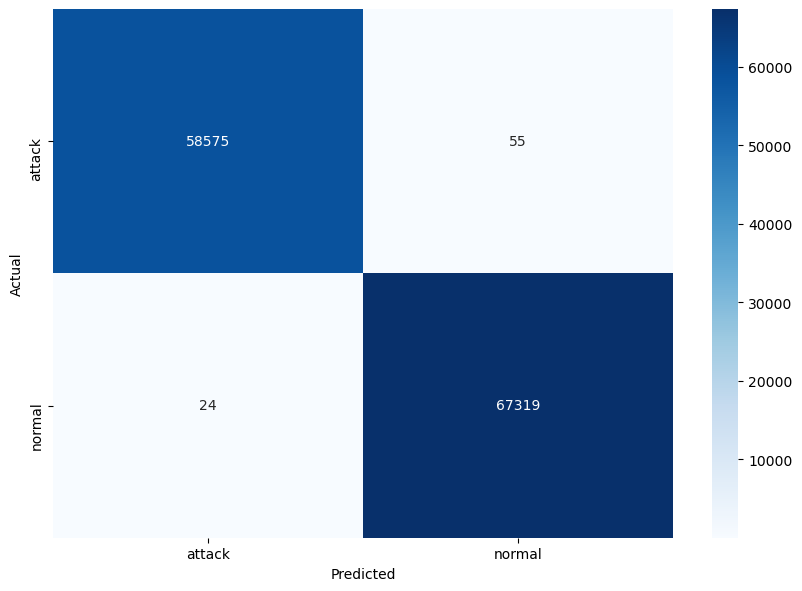

In [169]:
plt.figure(figsize =(10,7), dpi = 100)
sns.heatmap(cm_train, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_set_label_mapping.keys(),
           yticklabels = train_set_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [173]:
metrics(train_set_labels, yhat_train)


Overall accuracy: 1.00


Classification report

              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     58630
      normal       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973


Accuracy per Class:

attack	 99.91
normal	 99.96


In [170]:
yhat_test = model.predict(test_set)
cm_test = tf.math.confusion_matrix(labels = test_set_labels, predictions = yhat_test)

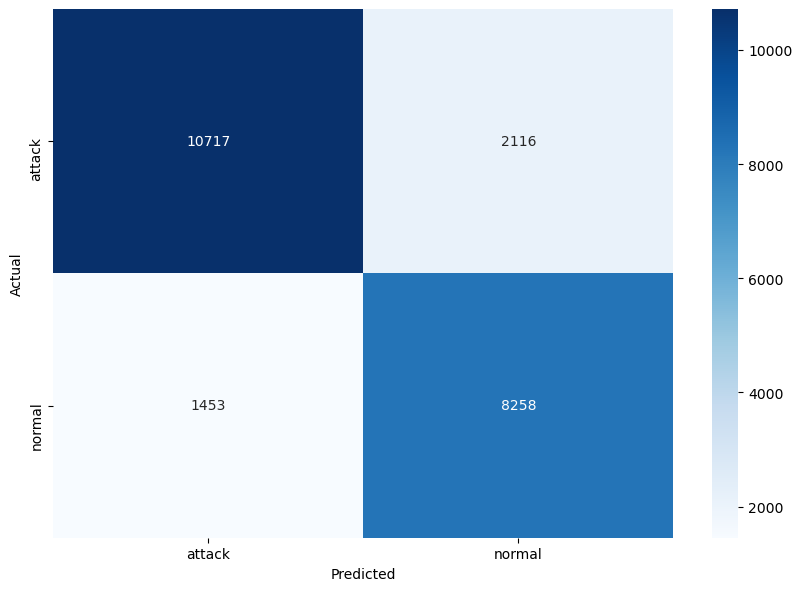

In [171]:
plt.figure(figsize =(10,7), dpi = 100)
sns.heatmap(cm_test, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_set_label_mapping.keys(),
           yticklabels = test_set_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [166]:
metrics(test_set_labels, yhat_test)


Overall accuracy: 0.84


Classification report

              precision    recall  f1-score   support

      attack       0.88      0.84      0.86     12833
      normal       0.80      0.85      0.82      9711

    accuracy                           0.84     22544
   macro avg       0.84      0.84      0.84     22544
weighted avg       0.84      0.84      0.84     22544


Accuracy per Class:

attack	 83.51
normal	 85.04
